# MobileNetV2 model 
## outline of the code

1. Import necessary libraries:
* Import TensorFlow, Keras, and other necessary libraries for building and training the model.

2. Load the dataset:
* Load the face mask dataset, which includes images of people with and without masks.

3. Data preprocessing:

* Resize the images to a consistent size (e.g., 224x224 pixels) and normalize the pixel values.
* Apply data augmentation techniques (e.g., rotation, flipping, zooming) to artificially increase the size and diversity of the dataset.
* Split the dataset into training and test sets for model evaluation.

4. Create a base model with transfer learning:

* Load a pre-trained model (MobileNetV2) as the base model.
* Remove the top layers to use the pre-trained model as a feature extractor.

5. Add regularization and custom layers:

* Apply regularization techniques (dropout) to reduce overfitting.
* Add custom layers on top of the base model to create a new model architecture tailored for the face mask classification task.

6. Compile the model:

* Compile the model with an optimizer (Adam), loss function (binary_crossentropy), and metric (accuracy).


7. Train the model:

* Train the model on the training dataset for a specified number of epochs, using the test dataset for validation.

8. Evaluate the model:

* Assess the model's performance on the test dataset and report the test accuracy.


In this repo, we implements a face mask detection model using transfer learning and data augmentation, with regularization techniques and a custom model architecture. The model is trained on a dataset of images of people with and without masks and evaluated on a separate test dataset to measure its performance.

In [10]:
import boto3
import tensorflow.compat.v2 as tf
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.regularizers import l2
from umap import UMAP
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import transformers
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer

tf.keras.backend.set_image_data_format('channels_first')

s3 = boto3.resource('s3')
bucket_name = 'dalle2images'
real_image_paths = []
fake_image_paths = []
real_labels = []
fake_labels = []

# loop through the images in your S3 bucket and append them to their respective lists:
for obj in s3.Bucket(bucket_name).objects.all():
    if obj.key.endswith('.png') and obj.key.startswith('real'):
        real_image_paths.append(obj.key)
        real_labels.append(0)
    elif obj.key.endswith('.png') and obj.key.startswith('fake'):
        fake_image_paths.append(obj.key)
        fake_labels.append(1)

In [3]:
# randomly select 10000 images (5000 real, 5000 fake) from your bucket
n_images = 100
n_real = n_fake = n_images // 2
real_samples = np.random.choice(real_image_paths, n_real, replace=False)
fake_samples = np.random.choice(fake_image_paths, n_fake, replace=False)
sample_paths = np.concatenate([real_samples, fake_samples])

images = []
orig_images = []  # Added: Store original images before preprocessing
labels = []
image_size = (224, 224)

for i, path in enumerate(sample_paths):
    img = s3.Object(bucket_name, path)
    img = Image.open(img.get()['Body'])
    img = img.resize(image_size, Image.ANTIALIAS)

    orig_img = np.array(img)  # Added: Store original image before preprocessing
    orig_images.append(orig_img)  # Added: Append original image to the list

    img = np.array(img).transpose((2, 0, 1))  # Change image format to channels_first
    img = img[..., ::-1]  # Convert from RGB to BGR format
    img = preprocess_input(img)

    images.append(img)
    labels.append(0 if path.startswith('real') else 1)

images = np.stack(images)
orig_images = np.stack(orig_images)  # Added: Stack original images
labels = np.array(labels)

/var/folders/y2/rmtghvx11dsdnn88ldv2d4w00000gn/T/ipykernel_1495/2816259070.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize(image_size, Image.ANTIALIAS)


In [4]:
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)
train_orig_images, test_orig_images, _, _ = train_test_split(orig_images, labels, test_size=0.2, random_state=42)  # Added: Split original images

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

train_dataset = train_dataset.shuffle(buffer_size=len(train_images), reshuffle_each_iteration=True)

batch_size = 32
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# Load the pre-trained MobileNetV2 model without the top layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(3, 224, 224))



Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [5]:

# Freeze the base model's layers
for layer in base_model.layers:
    layer.trainable = False

# Add the data augmentation layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
])

# Define the regularization strength
reg_strength = 0.001

# Create a new model using the base model and adding custom top layers
model = tf.keras.models.Sequential([
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(reg_strength)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(reg_strength)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(reg_strength)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 10
history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset)

# Evaluate the model
loss, accuracy = model.evaluate(test_dataset)
print("Test accuracy: {:.2f}%".format(accuracy * 100))

Epoch 1/10


2023-04-17 07:56:18.491746: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


250/250 [==============================] - 51s 193ms/step - loss: 1.1394 - accuracy: 0.4980 - val_loss: 0.9771 - val_accuracy: 0.5070
Epoch 2/10
250/250 [==============================] - 46s 185ms/step - loss: 0.9233 - accuracy: 0.5060 - val_loss: 0.8676 - val_accuracy: 0.5255
Epoch 3/10
250/250 [==============================] - 46s 183ms/step - loss: 0.8389 - accuracy: 0.5028 - val_loss: 0.8089 - val_accuracy: 0.5955
Epoch 4/10
250/250 [==============================] - 46s 184ms/step - loss: 0.7928 - accuracy: 0.5125 - val_loss: 0.7609 - val_accuracy: 0.5070
Epoch 5/10
250/250 [==============================] - 47s 190ms/step - loss: 0.7655 - accuracy: 0.5066 - val_loss: 0.7535 - val_accuracy: 0.5050
Epoch 6/10
250/250 [==============================] - 47s 187ms/step - loss: 0.7443 - accuracy: 0.5145 - val_loss: 0.7229 - val_accuracy: 0.6600
Epoch 7/10
250/250 [==============================] - 49s 194ms/step - loss: 0.7297 - accuracy: 0.5113 - val_loss: 0.6972 - val_accuracy: 0.6

In [6]:
# model.save_weights('my_model_weights.h5')
# # Save the Keras model
# model.save('my_keras_model.h5')

model.save('mobilemodel_v2')

INFO:tensorflow:Assets written to: mobilemodel_v2/assets


INFO:tensorflow:Assets written to: mobilemodel_v2/assets


In [7]:
model.build

<bound method Sequential.build of <keras.engine.sequential.Sequential object at 0x299104fa0>>

In [8]:
from huggingface_hub.keras_mixin import push_to_hub_keras
push_to_hub_keras(model, "monile_v2_fake_image_detection")

INFO:tensorflow:Assets written to: /var/folders/y2/rmtghvx11dsdnn88ldv2d4w00000gn/T/tmpaigk6o7g/scottlai/monile_v2_fake_image_detection/assets


INFO:tensorflow:Assets written to: /var/folders/y2/rmtghvx11dsdnn88ldv2d4w00000gn/T/tmpaigk6o7g/scottlai/monile_v2_fake_image_detection/assets


saved_model.pb:   0%|          | 0.00/3.82M [00:00<?, ?B/s]

keras_metadata.pb:   0%|          | 0.00/554k [00:00<?, ?B/s]

variables.data-00000-of-00001:   0%|          | 0.00/10.7M [00:00<?, ?B/s]

fingerprint.pb:   0%|          | 0.00/58.0 [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

'https://huggingface.co/scottlai/monile_v2_fake_image_detection/tree/main/'

In [137]:
import huggingface_hub as hf_hub
hf_api = hf_hub.HfApi()
repos = hf_api.list_repos()
print(repos)


AttributeError: 'HfApi' object has no attribute 'list_repos'

In [141]:
import huggingface_hub as hf_hub
hf_api = hf_hub.HfApi()
hf_api.delete_repo('dalle2_fake_image_detect')

In [142]:
# tokenizer = AutoTokenizer.from_pretrained('johngiorgi/keras-mobilenetV2')
# model = TFAutoModelForSequenceClassification.from_pretrained('johngiorgi/keras-mobilenetV2')
# model.load_weights('/Users/scottlai/Desktop/coding_project/705project/DallE2-ai-generator-scott/DallE2-ai-generator-scott/model_train/my_model_weights.h5')
hf_hub_model_id = hf_hub.create_repo('dalle2_fake_image_detect')
hf_hub.upload_file('my_keras_model.h5', hf_hub_model_id)


HfHubHTTPError: 500 Server Error: Internal Server Error for url: https://huggingface.co/api/repos/create (Request ID: Root=1-643cd76a-1f31f3261774302302192c06)

Internal Error - We're working hard to fix this as soon as possible!

In [118]:

# Extract the features from the trained model for t-SNE visualization
features = model.predict(test_images)

umap = UMAP(n_components=2, random_state=42)
umap_features = umap.fit_transform(features)
umap_scaling_factor = 30  # Increase this value to increase the distance between points
umap_features = umap_features * umap_scaling_factor

13/13 [==============================] - 1s 110ms/step


/var/folders/y2/rmtghvx11dsdnn88ldv2d4w00000gn/T/ipykernel_23454/3403965823.py:17: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img_resized = Image.fromarray(img).resize((int(img.shape[0] * scale_factor), int(img.shape[1] * scale_factor)), Image.ANTIALIAS)


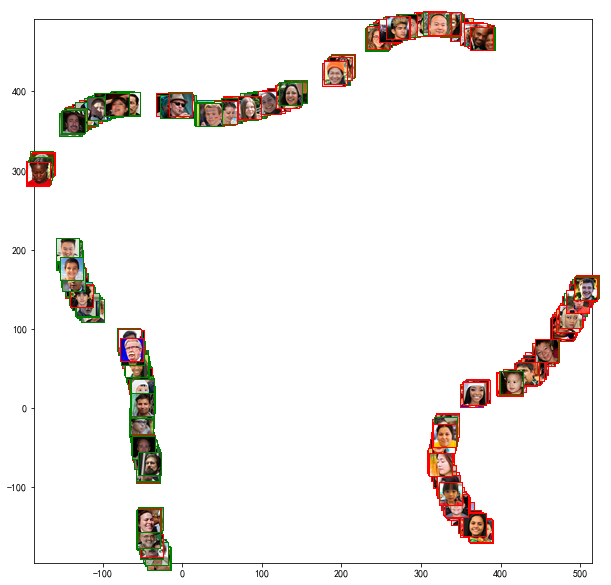

In [119]:

import matplotlib.pyplot as plt
import matplotlib.offsetbox as offsetbox
import numpy as np
from pyqtree import Index

fig, ax = plt.subplots(figsize=(10, 10))

# Scaling factor to control the size of the displayed images
scale_factor = 0.1
border_thickness = 1

# Modify the visualization loop to use test_orig_images instead of test_images
for i, (x, y) in enumerate(umap_features):
    img = test_orig_images[i]  # Load the original image
    
    # Resize the image and add a colored border
    img_resized = Image.fromarray(img).resize((int(img.shape[0] * scale_factor), int(img.shape[1] * scale_factor)), Image.ANTIALIAS)
    border_color = 'red' if test_labels[i] == 1 else 'green'
    bordered_image = Image.new('RGB', (img_resized.width + 2 * border_thickness, img_resized.height + 2 * border_thickness), border_color)
    bordered_image.paste(img_resized, (border_thickness, border_thickness))
    
    # Add the image to the plot
    imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(bordered_image), (x, y), frameon=False)
    ax.add_artist(imagebox)

# Set the plot limits and display the plot
ax.set_xlim(umap_features[:, 0].min() - 5, umap_features[:, 0].max() + 5)
ax.set_ylim(umap_features[:, 1].min() - 5, umap_features[:, 1].max() + 5)
plt.show()


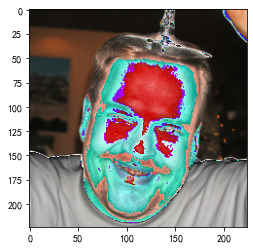

In [76]:
import matplotlib.pyplot as plt

# Load an example image
img = test_images[0]

# Rescale the image from [0, 1] to [0, 255] and convert to uint8
img = (img * 255).astype(np.uint8)

# Transpose the image to have shape (224, 224, 3) and display it
img = img.transpose(1, 2, 0)
plt.imshow(img)
plt.show()


NameError: name 'umap_features' is not defined

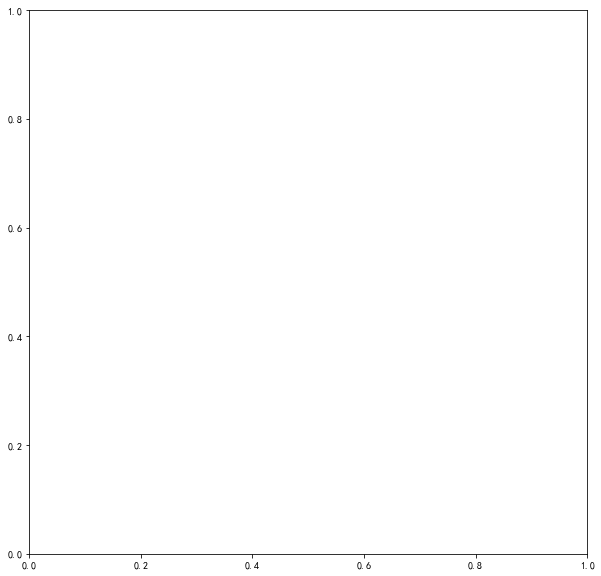

In [9]:
import numpy as np
from pyqtree import Index
import matplotlib.pyplot as plt
import matplotlib.offsetbox as offsetbox
import numpy as np
from pyqtree import Index

fig, ax = plt.subplots(figsize=(10, 10))

# Initialize the QuadTree with a bounding box covering the entire UMAP features range
bbox = (umap_features[:, 0].min(), umap_features[:, 1].min(), umap_features[:, 0].max(), umap_features[:, 1].max())
quadtree = Index(bbox)

# Add a padding factor to increase the space between images
padding_factor = 1.2

# Loop through the UMAP features
for i, (x, y) in enumerate(umap_features):
    img = test_orig_images[i]

    # Resize the image
    img_resized = Image.fromarray(img).resize((int(img.shape[0] * scale_factor), int(img.shape[1] * scale_factor)), Image.ANTIALIAS)
    border_color = 'red' if test_labels[i] == 1 else 'green'
    bordered_image = Image.new('RGB', (img_resized.width + 2 * border_thickness, img_resized.height + 2 * border_thickness), border_color)
    bordered_image.paste(img_resized, (border_thickness, border_thickness))

    # Create the bounding box for the image and check for collisions in the QuadTree
    half_width = img_resized.width / 2 * padding_factor
    half_height = img_resized.height / 2 * padding_factor
    image_bbox = (x - half_width, y - half_height, x + half_width, y + half_height)

    # If there are no collisions, insert the image into the QuadTree and add the image to the plot
    if not quadtree.intersect(image_bbox):
        quadtree.insert(item=i, bbox=image_bbox)
        imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(bordered_image), (x, y), frameon=False)
        ax.add_artist(imagebox)

# Set the plot limits and display the plot
ax.set_xlim(umap_features[:, 0].min() - 5, umap_features[:, 0].max() + 5)
ax.set_ylim(umap_features[:, 1].min() - 5, umap_features[:, 1].max() + 5)
plt.show()



/var/folders/y2/rmtghvx11dsdnn88ldv2d4w00000gn/T/ipykernel_23454/301511735.py:40: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img_resized = Image.fromarray(img).resize((int(img.shape[0] * scale_factor), int(img.shape[1] * scale_factor)), Image.ANTIALIAS)


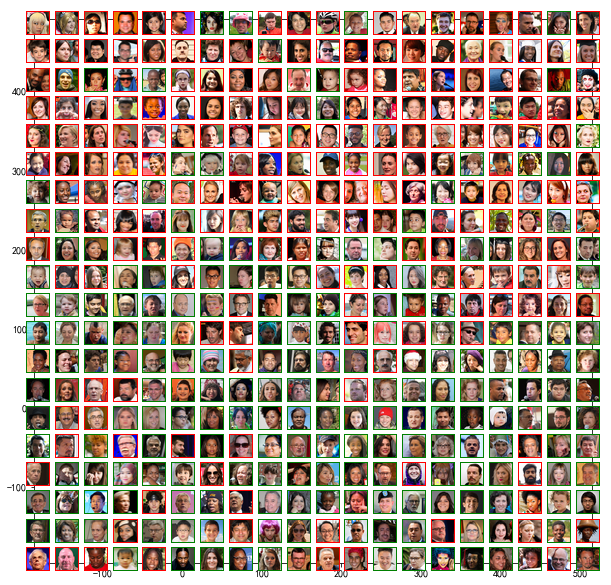

In [121]:
import numpy as np
from pyqtree import Index
import matplotlib.pyplot as plt
import matplotlib.offsetbox as offsetbox
import numpy as np
from pyqtree import Index

fig, ax = plt.subplots(figsize=(10, 10))


# Sort the images by their UMAP coordinates
sorted_indices = np.lexsort((umap_features[:, 1], umap_features[:, 0]))

# Calculate the number of rows and columns for the grid
n_rows = int(np.ceil(np.sqrt(len(umap_features))))
n_columns = n_rows

# Calculate the range of x and y coordinates
x_range = umap_features[:, 0].max() - umap_features[:, 0].min()
y_range = umap_features[:, 1].max() - umap_features[:, 1].min()

# Calculate the spacing between images in the grid
x_spacing = x_range / (n_columns - 1)
y_spacing = y_range / (n_rows - 1)

# Initialize the grid
grid = np.zeros((n_rows, n_columns))

# Loop through the sorted images and place them in the grid
for i, index in enumerate(sorted_indices):
    row = i // n_columns
    column = i % n_columns

    # Calculate the x and y coordinates for the current image
    x = umap_features[:, 0].min() + column * x_spacing
    y = umap_features[:, 1].min() + row * y_spacing

    # Load and resize the image
    img = test_orig_images[index]
    img_resized = Image.fromarray(img).resize((int(img.shape[0] * scale_factor), int(img.shape[1] * scale_factor)), Image.ANTIALIAS)
    border_color = 'red' if test_labels[index] == 1 else 'green'
    bordered_image = Image.new('RGB', (img_resized.width + 2 * border_thickness, img_resized.height + 2 * border_thickness), border_color)
    bordered_image.paste(img_resized, (border_thickness, border_thickness))

    # Add the image to the plot
    imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(bordered_image), (x, y), frameon=False)
    ax.add_artist(imagebox)

# Set the plot limits and display the plot
ax.set_xlim(umap_features[:, 0].min() - 5, umap_features[:, 0].max() + 5)
ax.set_ylim(umap_features[:, 1].min() - 5, umap_features[:, 1].max() + 5)
plt.show()


/var/folders/y2/rmtghvx11dsdnn88ldv2d4w00000gn/T/ipykernel_23454/826226377.py:32: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img_resized = Image.fromarray(img).resize((int(img.shape[0] * scale_factor), int(img.shape[1] * scale_factor)), Image.ANTIALIAS)


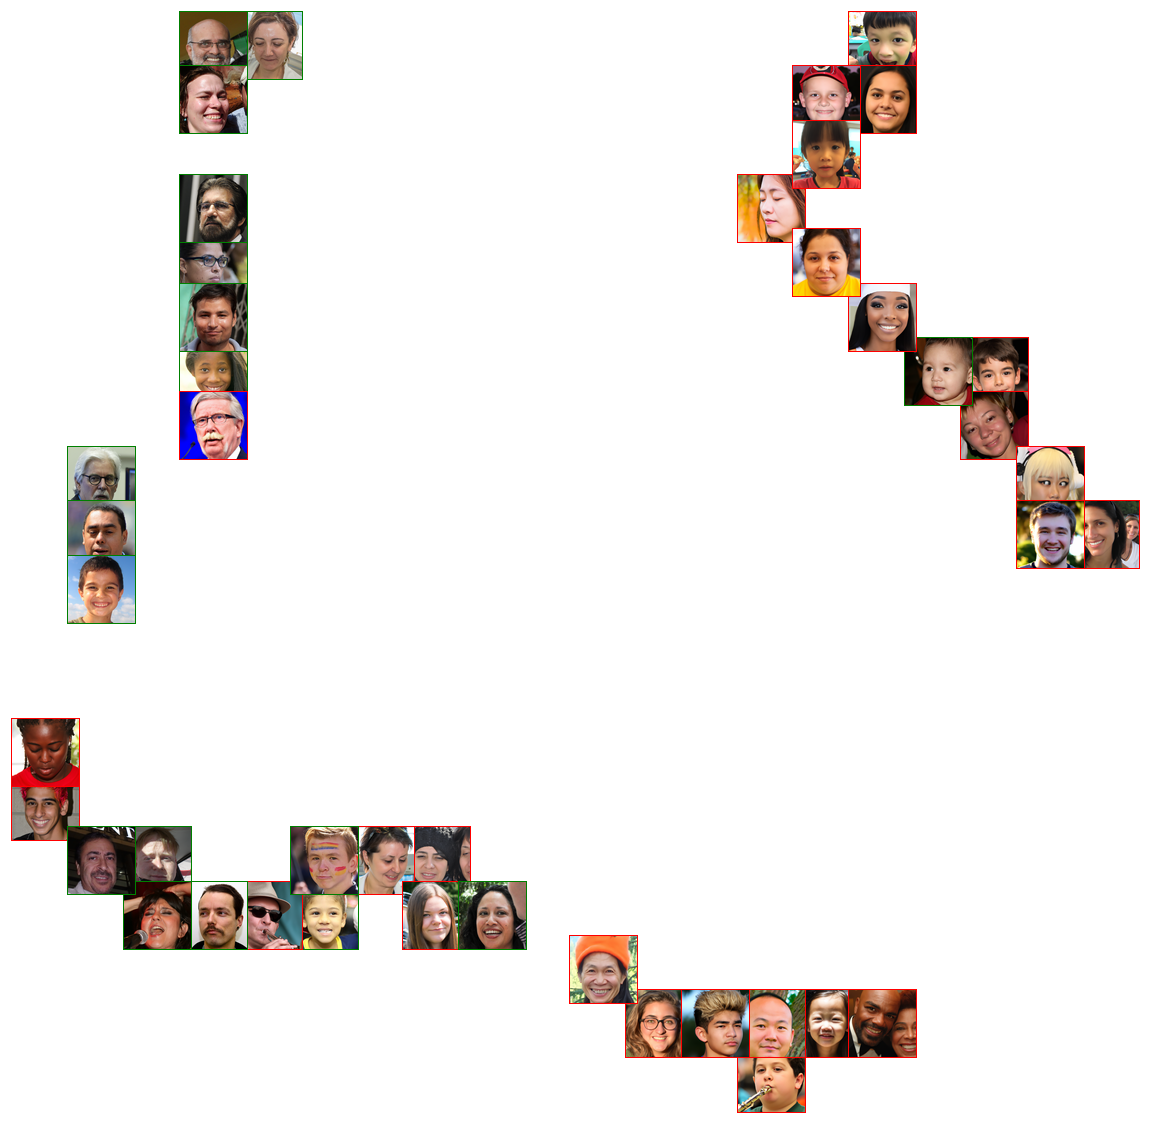

In [122]:
import numpy as np
from pyqtree import Index
import matplotlib.pyplot as plt
import matplotlib.offsetbox as offsetbox
import numpy as np
from pyqtree import Index

fig, ax = plt.subplots(figsize=(20, 20))
scale_factor = 0.3
border_thickness = 1
# Normalize UMAP coordinates
normalized_umap = (umap_features - umap_features.min(axis=0)) / (umap_features.max(axis=0) - umap_features.min(axis=0))

# Calculate the number of rows and columns for the grid
n_rows = int(np.ceil(np.sqrt(len(test_orig_images))))
n_columns = n_rows

# Calculate the indices for rows and columns
row_indices = (normalized_umap[:, 1] * (n_rows - 1)).astype(int)
column_indices = (normalized_umap[:, 0] * (n_columns - 1)).astype(int)

# Calculate the spacing between images in the grid
x_spacing = 1 / (n_columns - 1)
y_spacing = 1 / (n_rows - 1)

for i, (row, column) in enumerate(zip(row_indices, column_indices)):
    img = test_orig_images[i]

    x = column * x_spacing
    y = row * y_spacing

    img_resized = Image.fromarray(img).resize((int(img.shape[0] * scale_factor), int(img.shape[1] * scale_factor)), Image.ANTIALIAS)
    border_color = 'red' if test_labels[i] == 1 else 'green'
    bordered_image = Image.new('RGB', (img_resized.width + 2 * border_thickness, img_resized.height + 2 * border_thickness), border_color)
    bordered_image.paste(img_resized, (border_thickness, border_thickness))

    imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(bordered_image), (x, y), frameon=False)
    ax.add_artist(imagebox)

ax.set_xlim(0 - x_spacing / 2, 1 + x_spacing / 2)
ax.set_ylim(0 - y_spacing / 2, 1 + y_spacing / 2)
plt.gca().invert_yaxis()
plt.axis('off')
plt.show()


/var/folders/y2/rmtghvx11dsdnn88ldv2d4w00000gn/T/ipykernel_23454/1391075324.py:34: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img_resized = Image.fromarray(img).resize((int(img.shape[0] * scale_factor), int(img.shape[1] * scale_factor)), Image.ANTIALIAS)


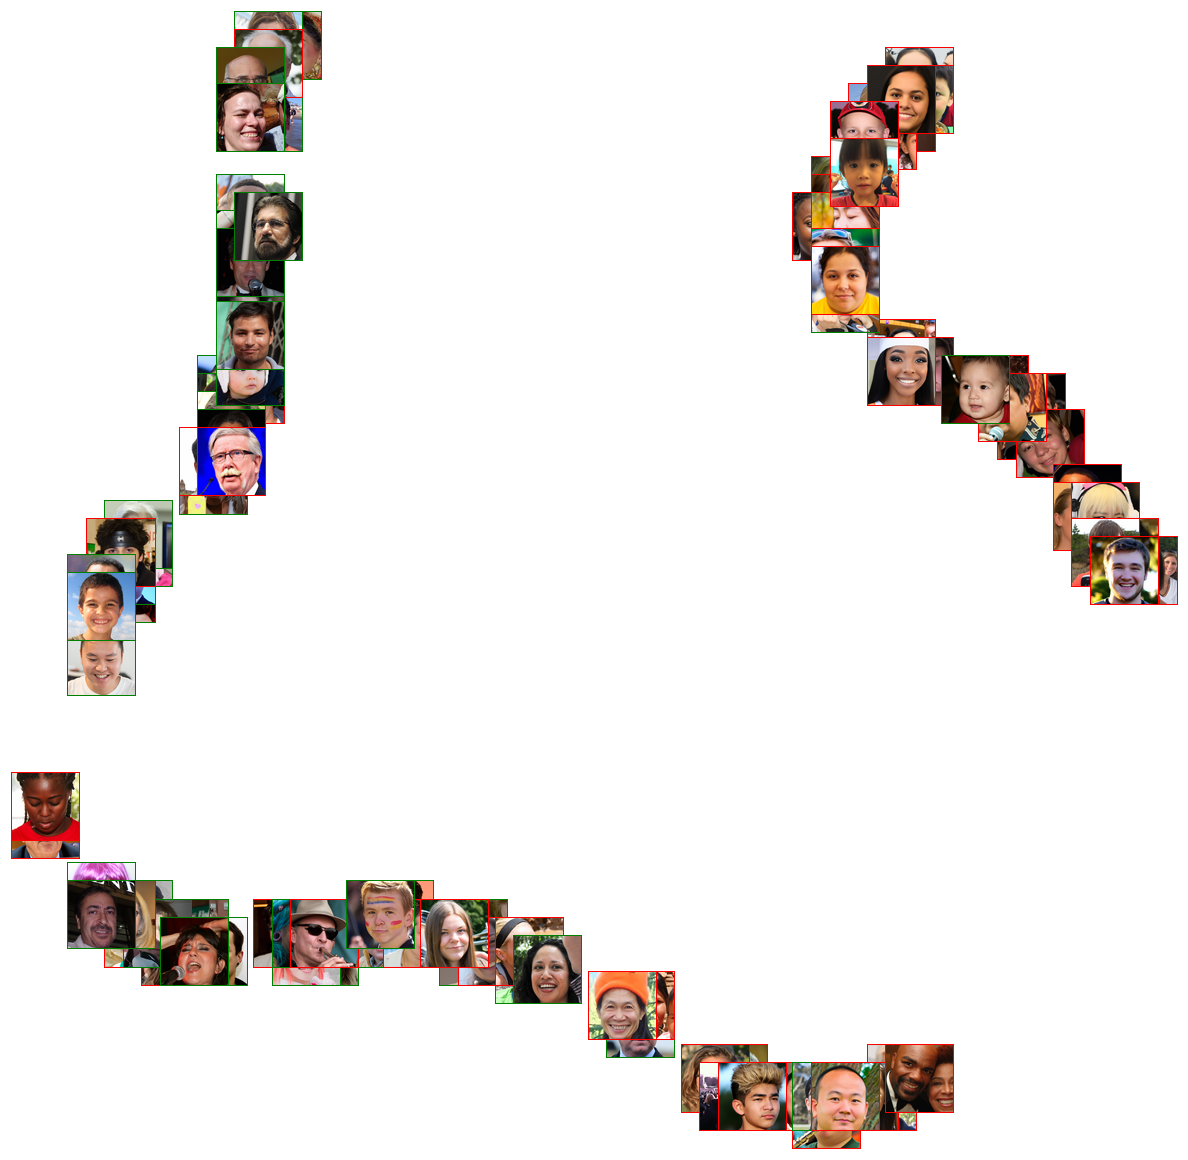

In [115]:
import numpy as np
from pyqtree import Index
import matplotlib.pyplot as plt
import matplotlib.offsetbox as offsetbox
import numpy as np
from pyqtree import Index

fig, ax = plt.subplots(figsize=(20, 20))
scale_factor = 0.3
border_thickness = 1

# Normalize UMAP coordinates
normalized_umap = (umap_features - umap_features.min(axis=0)) / (umap_features.max(axis=0) - umap_features.min(axis=0))

# Calculate the number of rows and columns for the grid
grid_size_factor = int(1 / scale_factor)  # Increase this value to add more space between images
n_rows = int(np.ceil(np.sqrt(len(test_orig_images)) * grid_size_factor))
n_columns = n_rows

# Calculate the indices for rows and columns
row_indices = (normalized_umap[:, 1] * (n_rows - 1)).astype(int)
column_indices = (normalized_umap[:, 0] * (n_columns - 1)).astype(int)

# Calculate the spacing between images in the grid
x_spacing = 1 / (n_columns - 1)
y_spacing = 1 / (n_rows - 1)

for i, (row, column) in enumerate(zip(row_indices, column_indices)):
    img = test_orig_images[i]

    x = column * x_spacing
    y = row * y_spacing

    img_resized = Image.fromarray(img).resize((int(img.shape[0] * scale_factor), int(img.shape[1] * scale_factor)), Image.ANTIALIAS)
    border_color = 'red' if test_labels[i] == 1 else 'green'
    bordered_image = Image.new('RGB', (img_resized.width + 2 * border_thickness, img_resized.height + 2 * border_thickness), border_color)
    bordered_image.paste(img_resized, (border_thickness, border_thickness))

    imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(bordered_image), (x, y), frameon=False)
    ax.add_artist(imagebox)

ax.set_xlim(0 - x_spacing / 2, 1 + x_spacing / 2)
ax.set_ylim(0 - y_spacing / 2, 1 + y_spacing / 2)
plt.gca().invert_yaxis()
plt.axis('off')
plt.show()
